# Figure 4

## Imports

In [20]:
import os
import sys
import inspect
import numpy as np
from pathlib import Path
from glob import glob
from collections import OrderedDict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

# imports from ../scripts directory
sys.path.append(os.path.abspath(os.path.join("..", "scripts")))
from common import *
from coord_converter import star_to_df
from build_corrs import fill_upper_triangle

## Globals

In [39]:
class_names = ["GT Classes", "GT", "Consensus"]  # MUST match order of inputs passed to build_corrs.py
gt_name = "GT Classes"
n_max_classes = 400
score_clip = None  # or some tuple like (0, 1)

scores_dir = Path("~/Desktop/imppel_fig4_data/n40_test").expanduser()
out_dir = Path("~/Desktop/imppel_fig4_data/n40_test").expanduser()
data_dir = Path("~/Desktop/imppel_fig4_data/src/").expanduser()

## Setup

Validate/normalize input paths.

In [41]:
mrcs_paths = [str(data_dir / Path(n).as_posix()) + ".mrcs" for n in class_names]
star_paths = [str(data_dir / Path(n).as_posix()) + ".star" for n in class_names]
mrcs_paths = [p for p in mrcs_paths if os.path.exists(p)]
star_paths = [p for p in star_paths if os.path.exists(p)]

First combine all input score .npy files into a single array.

In [3]:
def combine_corr_data(data_dir):
    out = None
    files = glob(str(data_dir / "scores_*.npy"))
    if not files:
        log(f"no files found in {data_dir}")
        return None
    for f in tqdm(files):
        arr = np.load(f)
        if out is None:
            out = arr
        else:
            if arr.shape == out.shape:
                idx = np.where(~np.isnan(arr))
                out[idx] = arr[idx]
            else:
                log(f"corr data shapes do not match: {arr.shape} != {out.shape}", lvl=2)
                return None
    return out.T

max_scores = combine_corr_data(scores_dir)

  0%|          | 0/1 [00:00<?, ?it/s]

Read input .mrcs and .star files into a dictionary.

In [42]:
def read_class_avgs(mrcs_paths, star_paths, n_max_classes=None):
    if not star_paths:
        star_paths = [None for _ in mrcs_paths]

    class_avgs = OrderedDict()
    class_idx = 0
    for m, s in tqdm(zip(mrcs_paths, star_paths), total=len(mrcs_paths)):
        mrcs = read_mrc(m, mmap=True)
        n_cls = len(mrcs) if n_max_classes is None else min(n_max_classes, len(mrcs))
        idxs = list(range(class_idx, class_idx + n_cls))
        class_idx = class_idx + n_cls
        class_avgs[Path(m).stem] = {
            "mrcs": mrcs[:n_cls],
            "star": None if not s else star_to_df(s),
            "name": Path(m).stem,
            "idxs": idxs,
        }

    # reorder class avg stacks by particle distribution if STAR available
    for stem, data in class_avgs.items():
        if "star" not in data or data["star"] is None:
            continue

        distr = data["star"]["_rlnClassDistribution"].to_numpy()
        sorted_idx = np.argsort(distr)[::-1]
        class_avgs[stem]["sorted_idx"] = sorted_idx
        class_avgs[stem]["sorted_distr"] = np.take_along_axis(
            distr, sorted_idx, axis=None
        )
        # we use [:, None, None] to broadcast index to 3D like mrcs stack
        class_avgs[stem]["mrcs"] = np.take_along_axis(
            data["mrcs"], sorted_idx[:, None, None], axis=0
        )

    return class_avgs

class_avgs = read_class_avgs(mrcs_paths, star_paths, n_max_classes=n_max_classes)

  0%|          | 0/3 [00:00<?, ?it/s]

## Max score histogram

Run the histogram.

  0%|          | 0/3 [00:00<?, ?it/s]

No handles with labels found to put in legend.
/Users/seb/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


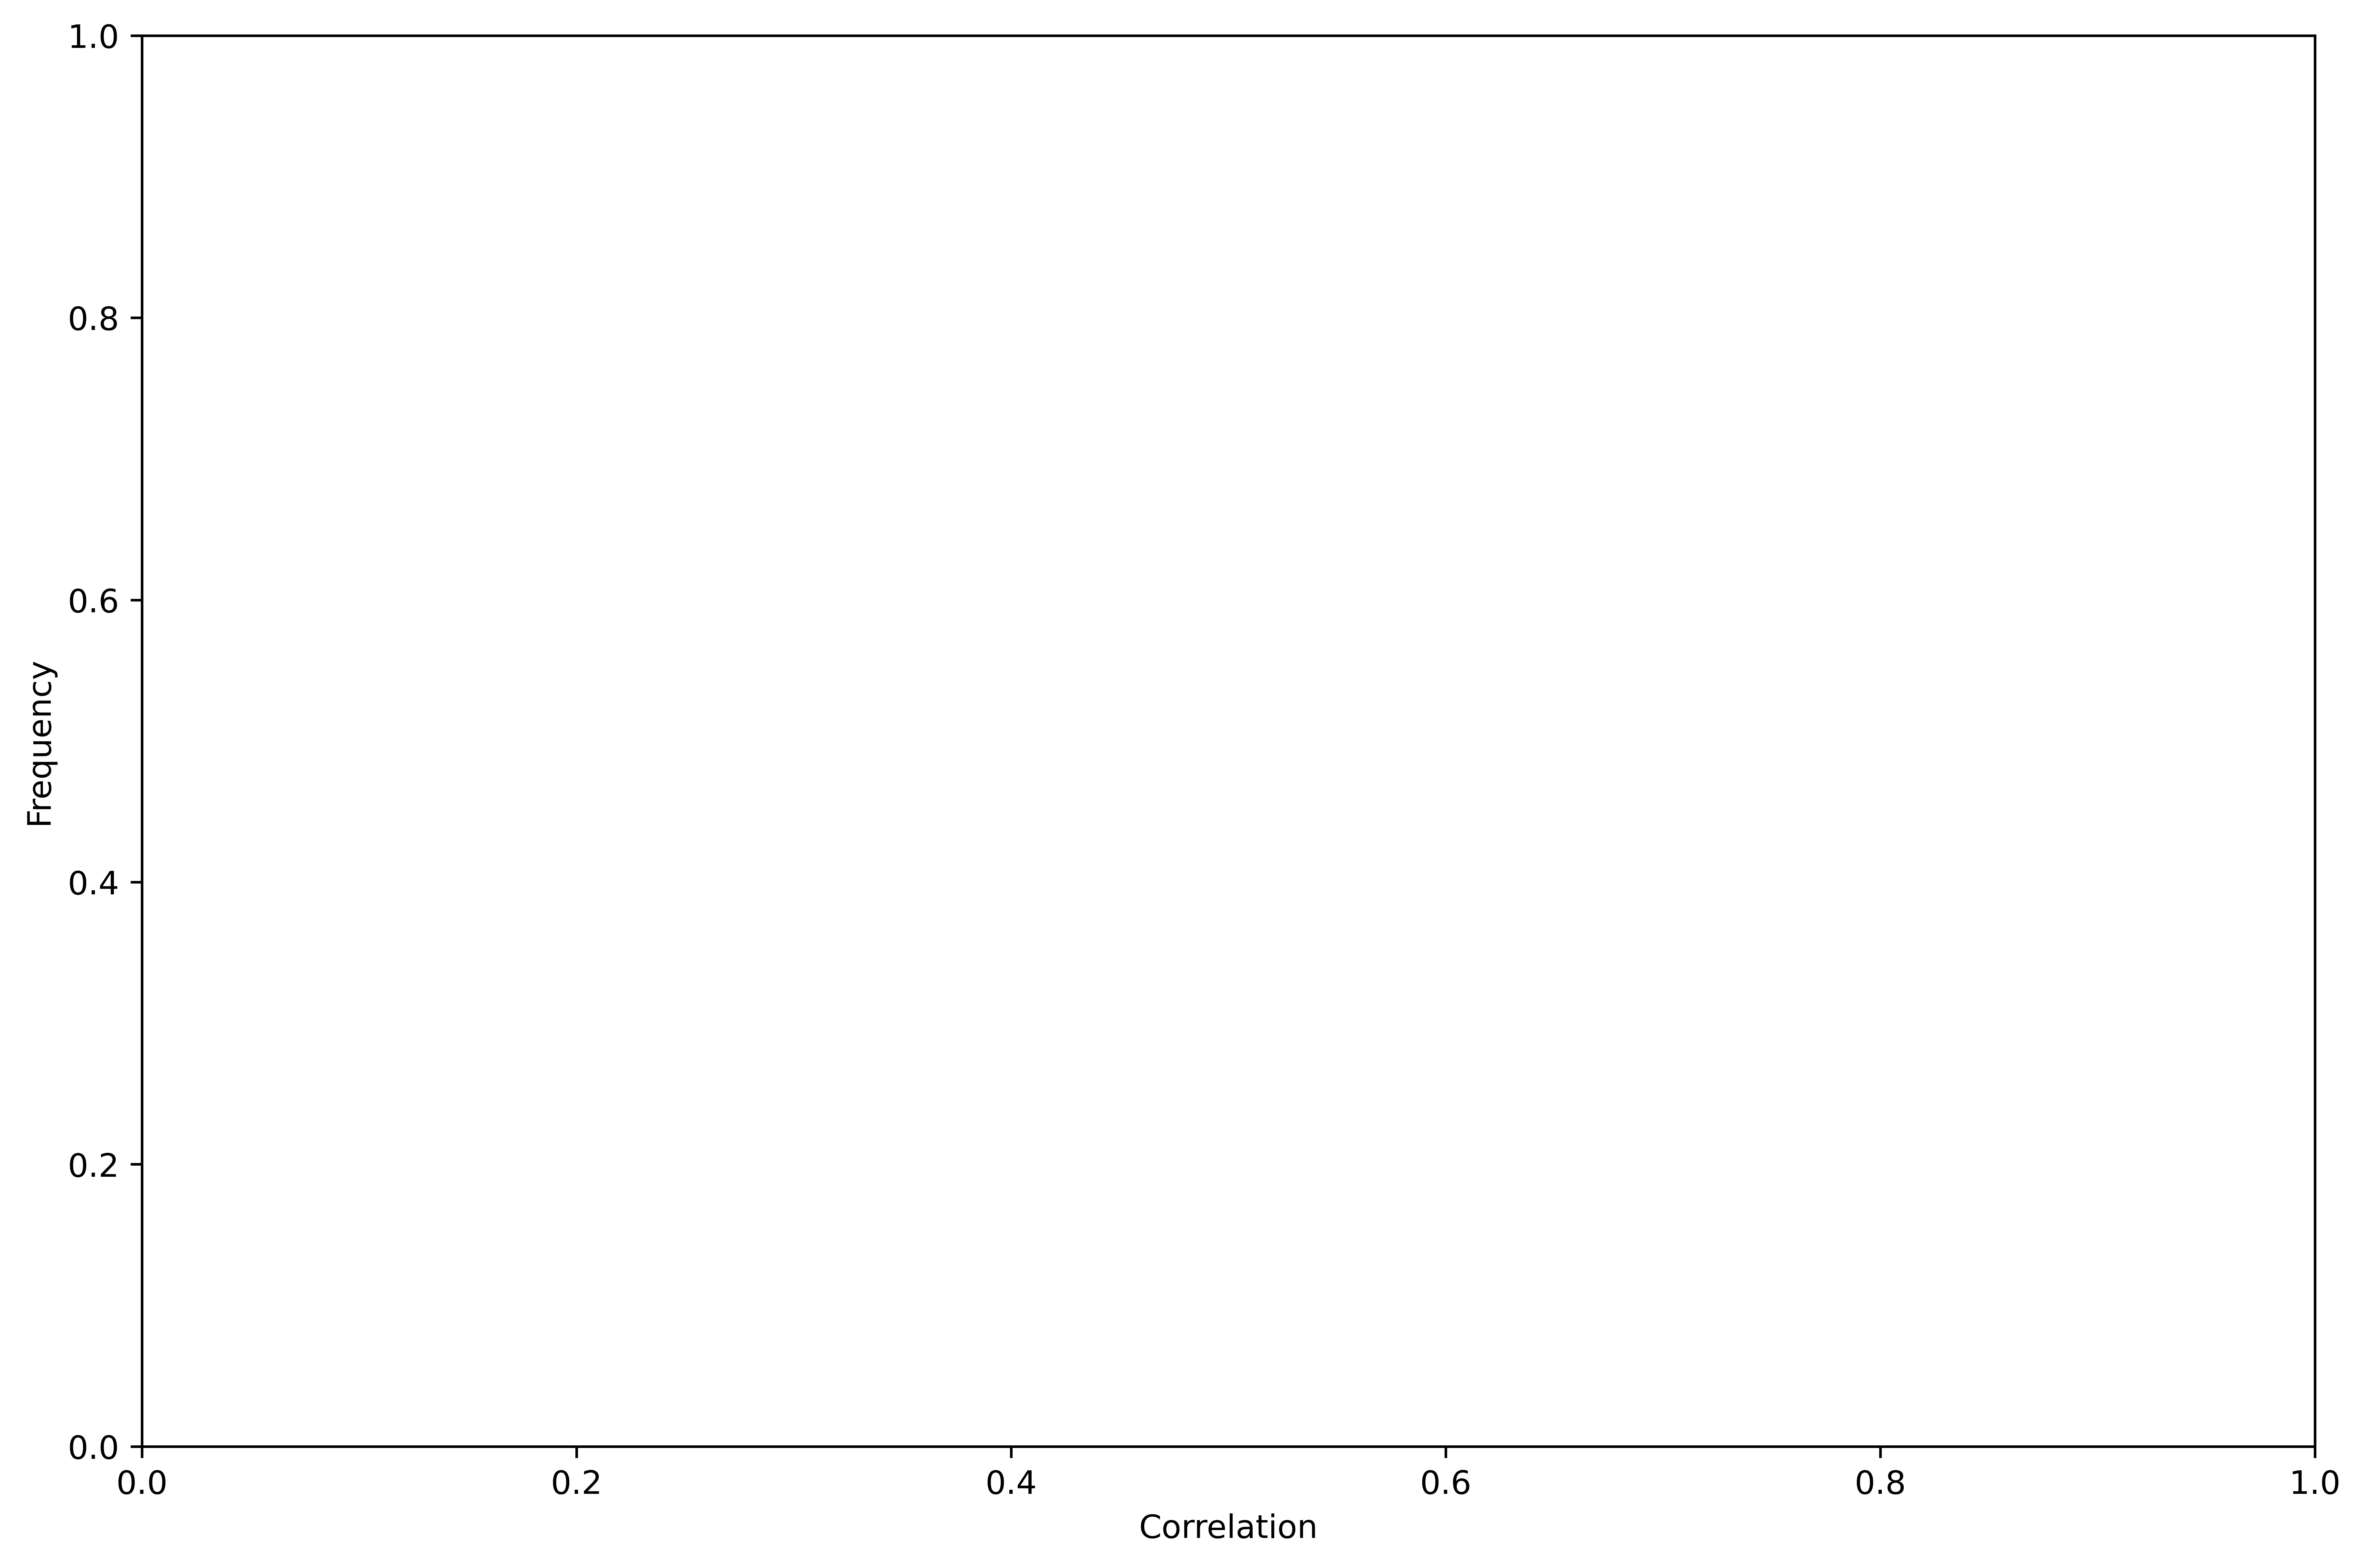

In [22]:
scores = max_scores.copy()

# correlations are clipped to the range indicated by score_clip
if score_clip is not None:
    scores = np.clip(scores, *score_clip)

# select only GT-vs-rest scores
# in mask, cells to be cleared are set to True
l = scores.shape[0]
gt_start, gt_end = class_avgs[gt_name]["idxs"][0], class_avgs[gt_name]["idxs"][-1] + 1
mask = np.ones_like(scores, dtype=bool)  # make all-True mask
mask[:, gt_start : gt_end] = False  # make GT-vs-all scores False down columns
mask[gt_start : gt_end, :] = True  # make GT-vs-GT scores True again
# fill_upper_triangle(mask)  # copy mask to upper-right triangle

# apply mask to scores
scores[mask] = np.nan

# get max score for each class avg against GT
# ignore RuntimeWarning
with warnings.catch_warnings():
    # nanmax throws RuntimeWarning if all scores are nan
    warnings.simplefilter("ignore")
    try:
        # find max with any ground truth for each particle
        # NOTE: think about the heatmap - maxes is the colmax from right to left
        #       (rightmost col first in the list, leftmost col last)
        #       so we reverse it to get it in same order as classes in class_avgs
        maxes = np.nanmax(scores, axis=0)[::-1]
    except ValueError:
        raise ValueError("scores array empty (skipping max score histogram)")

# plot histogram
hist_fig, hist_ax = plt.subplots(figsize=(12, 8), dpi=800)

# keep track of samples for later
samples = {k: {} for k in samp_xval_ranges.keys()}

for i, pckr_name in enumerate(tqdm(class_avgs.keys())):
    slice_start = class_avgs[pckr_name]["idxs"][0]
    slice_end = class_avgs[pckr_name]["idxs"][-1] + 1
    try:
        y, edges = np.histogram(
            maxes[slice(slice_start, slice_end)], bins=80, density=True
        )
    except ValueError:
        continue  # skip all-nan slices
    centers = 0.5 * (edges[1:] + edges[:-1])
    hist_ax.plot(centers, y, color=PICKER_COLORS[i], label=pckr_name)

    # sample particles
    if pckr_name in samp_xval_ranges:
        for x_rng in samp_xval_ranges[pckr_name]:
            # only take n_samp particles
            n_particles_added = 0
            samples[pckr_name][x_rng] = []
            for i in range(len(class_avgs[pckr_name]["mrcs"])):
                if n_particles_added >= n_samp:
                    break
                mrc = class_avgs[pckr_name]["mrcs"][i]
                score_idx = class_avgs[pckr_name]["idxs"][i]
                score = maxes[score_idx]
                if score >= x_rng[0] and score <= x_rng[1]:
                    samples[pckr_name][x_rng].append({"mrc": mrc, "score": score})
                    n_particles_added += 1

hist_ax.set_xlabel("Correlation")
hist_ax.set_ylabel("Frequency")
hist_ax.legend(loc="best", frameon=False)
plt.show()

Customize parameters for sample grid.

In [13]:
n_samp = 10
samp_xval_ranges={
    k: [(-0.1, 0), (0, 0.1), (0.34, 0.36), (0.39, 0.41), (0.44, 0.46)]
    for k in class_names
    if k != gt_name
}

Plot sample grid.

In [12]:
# plot sample grid
if not samp_xval_ranges:
    exit(0)

n_samp_grids = len(samp_xval_ranges.keys())
samp_fig = plt.figure(constrained_layout=True, figsize=(12, 8), dpi=600)
n_rows = sum(len(v) for v in samp_xval_ranges.values())
samp_gs = samp_fig.add_gridspec(nrows=n_rows, ncols=n_samp + 1)
pckr_offset = 0
for pckr_name, v in samples.items():
    for j, (x_rng, samp_imgs) in enumerate(v.items()):
        # add label for each row in col 0
        ax = samp_fig.add_subplot(samp_gs[pckr_offset + j, 0])
        ax.axis("off")
        ax.text(
            0.5,
            0.5,
            f"{pckr_name}\n{x_rng[0]}-{x_rng[1]}",
            va="center",
            ha="right",
            fontsize=8,
        )
        # add images to each row
        for k, img in enumerate(samp_imgs):
            ax = samp_fig.add_subplot(samp_gs[pckr_offset + j, k + 1])
            ax.axis("off")
            ax.imshow(img["mrc"], cmap="gray")
            ax.set_title(f"{img['score']:.3f}", fontsize=8)
    pckr_offset += len(v)
plt.savefig(out_dir / "score_hist_samples.png", bbox_inches="tight")

<Figure size 7200x4800 with 0 Axes>